In [1]:
import jax
import jax.numpy as np
import jax_cosmo as jc

import scipy.special as sysp
import sys,os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
%pylab inline
import os.path

sys.path.append('../../code/')
from mountaineer import Model,Chi2,Mountaineer
from paths import *

sys.path.append(ML_Path)
from mlalgos import BuildNN,Sequential

sys.path.append(Picasa_Path)
from gpr_train import GPRTrainer
from picasa import PICASA

import copy
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

from cobaya.run import run
from cobaya.log import LoggedError
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

from functools import partial

pic = PICASA()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/aseem/anaconda3/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['np']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

## Posterior Emulation with [Mountaineer](https://github.com/a-paranjape/mountaineer)

### DES Y1 Weak Lensing Shear model (courtesy Shivam Pandey)

In [3]:
Reduction_Fac = 0.25 # factor to multiply with covariance matrix, to approximate better data

(0.0, 2.0)

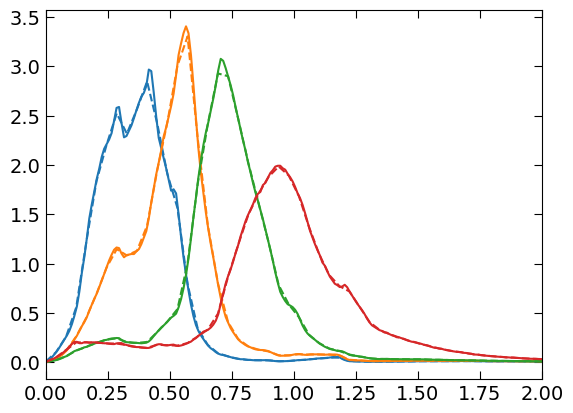

In [4]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('data/2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits
    !mv 2pt_NG_mcal_1110.fits data/.

nz_source=fits.getdata('data/2pt_NG_mcal_1110.fits', 6)

# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

z = linspace(0,2)
for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)

In [5]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta]

# # Let's try a round trip just to make sure
# p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
#               [1., 2.])
# print(unpack_params_vec(p))

# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]

    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl


## Let's get the covariance
f_sky = 1321./41253.
print("f_sky", f_sky)
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta) = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=f_sky, sparse=False)

    cov *= Reduction_Fac # reduce errors artificially
    
    return cov

jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

f_sky 0.03202191355780186


In [6]:
# Let's try it out
FiducialCosmo = partial(jc.Cosmology, sigma8=0.801,
                         Omega_c=0.2545,
                         Omega_b=0.0485,
                         h=0.682,
                         n_s=0.971,
                         w0=-1., Omega_k=0., wa=0.)

fid_cosmo = FiducialCosmo()
fid_params = get_params_vec(fid_cosmo, 
                            [1.2e-2, 1.2e-2, 1.2e-2, 1.2e-2],
                            [0.1e-2, -1.9e-2, 0.9e-2, -1.8e-2],
                            [0.5, 0.])

cov_mat = cov(fid_params)
# data = mu(fid_params).flatten()
rng = np.random.RandomState(1983)
data_mock = rng.multivariate_normal(mu(fid_params).flatten(),cov_mat)


# @jax.jit
# def get_loglike(params):
#     # First unpack parameter vector
#     cosmo, m, dz, (A, eta) = unpack_params_vec(params) 

#     # Build source nz with redshift systematic bias
#     nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
#                 for nzi, dzi in zip(nzs_s, dz)]

#     # Define IA model, z0 is fixed
#     b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    
#     # Define the lensing and number counts probe
#     probes = [jc.probes.WeakLensing(nzs_s_sys, 
#                                     ia_bias=b_ia,
#                                     multiplicative_bias=m)]
#     cl = jc.angular_cl.angular_cl(cosmo, ell, probes)
#     theory = cl.flatten()
#     diff = theory - data
#     chi2 = np.dot(diff, np.dot(np.linalg.inv(C), diff))
#     # unnormalized loglike
#     loglike = -0.5 * chi2
#     return loglike


/home/aseem/anaconda3/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


### Mountaineer setup

In [7]:
N_Params_Tot = 16

class DES_Y1_WLShear(Model):
    def __init__(self,n_params=16,fixed_params={}):
        # expect fixed_params to be dictionary with keys as subset of self.all_params.keys() and values of these params
        self.fixed_params = fixed_params
        n_tot = n_params + len(self.fixed_params.keys())
        if n_tot != N_Params_Tot:
            raise Exception('DES_Y1_WLShear works with 16 params, but {0:d} specified.'.format(n_tot))
            
        # self.all_params = {'a{0:d}'.format(p):0.0 for p in range(9)} # re-usable dictionary
        self.all_params = {'sig8':0.0,'Oc':0.0,'Ob':0.0,'h':0.0,'ns':0.0,'w0':0.0} # re-usable dictionary
        for m in range(1,5):
            self.all_params['m{0:d}'.format(m)] = 0.0
        for dz in range(1,5):
            self.all_params['dz{0:d}'.format(dz)] = 0.0
        self.all_params['A'] = 0.0
        self.all_params['eta'] = 0.0
        self.varied_params = list(self.all_params.keys())
        for par in self.fixed_params.keys():
            self.varied_params.remove(par)
            self.all_params[par] = self.fixed_params[par]
        # now self.varied_params is list of names of varied parameters and self.all_params is updated with fixed_params values
        print('varied params: ',self.varied_params)
        
        Model.__init__(self,n_params=n_params)
        self.n_data = data_mock.size

    def calc_model(self,X):
        p_this = self.params.T[0].copy()
        p = 0
        for key in self.varied_params:
            self.all_params[key] = p_this[p]
            p += 1
        try:
            out = mu(list(self.all_params.values())).flatten()
        except ValueError:
            # print("Exception at parameters:",self.params.T[0])
            out = np.array([1e30]*self.n_data)
            
        return self.rv(out[X[0]]) # X.shape = (1,n_samp)
    
    def calc_dmdtheta(self):
        # self.X will be available for the data set
        dmdtheta = np.zeros((self.n_params,self.X.shape[1])) # (n_params,n_samp)
        jac = jacobian(list(self.all_params.values())) # list of length n_params, each elem array of length self.n_data
        for p in range(len(self.varied_params)):
            allkeys = np.asarray(list(self.all_params.keys()))
            id_p = np.where(allkeys == self.varied_params[p])[0][0]
            dmdtheta[p] = jac[id_p][self.X[0]]
        
        return dmdtheta


In [8]:
Narrow = False

In [9]:
Vary_Cosmo = True
if Vary_Cosmo:
    Fixed_Params = {'m1':1.2e-2,'m2':1.2e-2,'m3':1.2e-2,'m4':1.2e-2,
                    'dz1':1e-3,'dz2':-1.9e-2,'dz3':9e-3,'dz4':-1.8e-2,'A':0.5,'eta':0.0}
else:
    Fixed_Params = {'sig8':0.801,'Oc':0.2545,'Ob':0.0485,'h':0.682,'ns':0.971,'w0':-1.0,
                    'm1':1.2e-2,'m2':1.2e-2,'m3':1.2e-2,'m4':1.2e-2}
N_evals_max = 1000
id_str = 'desY1' 
survey_frac = 0.02 # 0.05

N_Vary = N_Params_Tot-len(Fixed_Params.keys())
model = DES_Y1_WLShear(n_params=N_Vary,fixed_params=Fixed_Params)

X_all = np.arange(model.n_data)
n_samp = X_all.size
X_all = model.rv(X_all)

n_params = model.n_params
Y_all = model.rv(data_mock)

dof = X_all.shape[1] - n_params

id_str += '_lgNmax{0:.2f}'.format(np.log10(N_evals_max))
if Narrow:
    id_str += '_narrow'
if Vary_Cosmo:
    id_str += '_cosmo'
elif N_Vary < N_Params_Tot:
    id_str += '_np{0:d}'.format(N_Vary)

# best seems pLike_B2adam. checking 4k walks.
# id_str += '_pLike'
# id_str += '_B1sgdB2adam' # '_adam', '_sgd', '_B1adamB2sgd', '_B1sgdB2adam', '_B2adam', '_B1adam', ''

print('id_str:',id_str)
file_stem = 'walks/' + id_str

varied params:  ['sig8', 'Oc', 'Ob', 'h', 'ns', 'w0']
id_str: desY1_lgNmax3.00_cosmo


In [10]:
Walks_Exist = False

if Narrow:
    pass
else:
    param_mins = {'sig8':0.7,'Oc':0.2,'Ob':0.04,'h':0.65,'ns':0.9,'w0':-1.25,'m1':-0.05,'m2':-0.05,'m3':-0.05,'m4':-0.05,
                  'dz1':-0.025,'dz2':-0.030,'dz3':0.0,'dz4':-0.03,'A':0.0,'eta':-1.0}
    param_maxs = {'sig8':0.9,'Oc':0.4,'Ob':0.05,'h':0.75,'ns':1.1,'w0':-0.75,'m1':0.075,'m2':0.075,'m3':0.075,'m4':0.075,
                  'dz1':0.025,'dz2':0.015,'dz3':0.030,'dz4':0.03,'A':2.0,'eta':1.0}

for key in Fixed_Params.keys():
    del param_mins[key]
    del param_maxs[key]

loss_params = {'cov_mat':cov_mat}

dp = {'N_evals_max':N_evals_max,'survey_frac':survey_frac,'file_stem':file_stem,'model':DES_Y1_WLShear,'n_params':n_params,
      'param_mins':list(param_mins.values()),'param_maxs':list(param_maxs.values()),
      'X':X_all,'Y':Y_all,'val_frac':0.2,'loss':Chi2,'walks_exist':Walks_Exist,
      'seed':None,'verbose':True,'logfile':None,'loss_params':loss_params}

mnt = Mountaineer(data_pack=dp,fixed_params=Fixed_Params)

varied params:  ['sig8', 'Oc', 'Ob', 'h', 'ns', 'w0']
Mountaineer to explore loss land-scape!
... initialization done


Surveying using 20 locations 5 times...
... iteration 1
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 20 of 20 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 2; breaking.
... ... adjusting parameter ranges
... iteration 2
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 20 of 20 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 0; breaking.
... ... adjusting parameter ranges
... iteration 3
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 20 of 20 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 0; breaking.
... ... adjusting parameter ranges


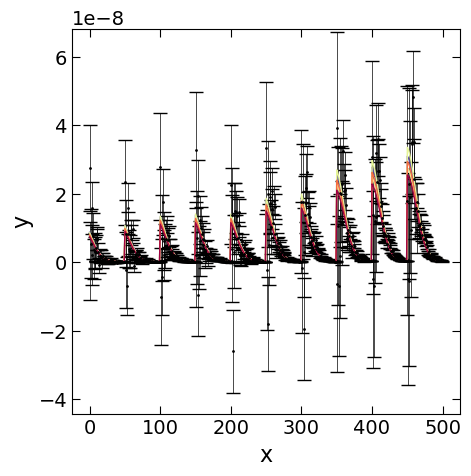

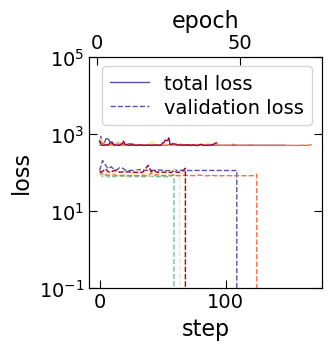

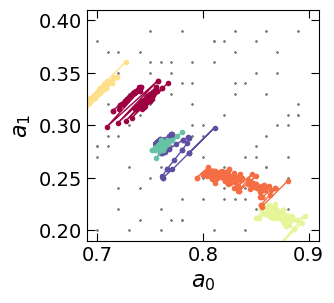

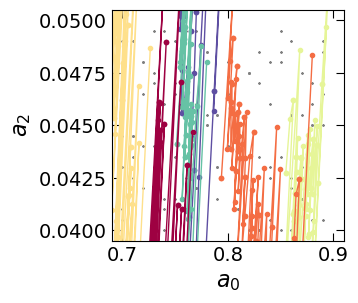

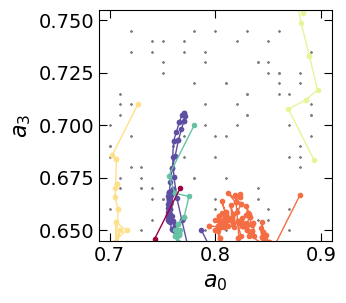

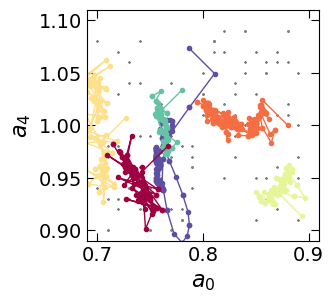

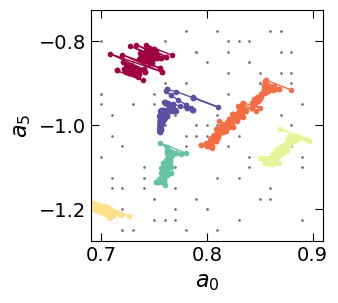

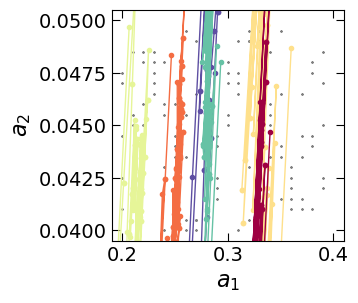

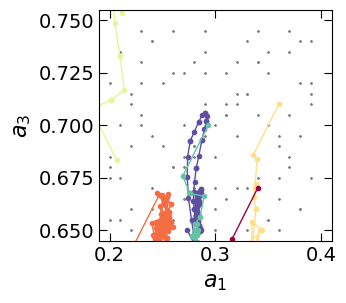

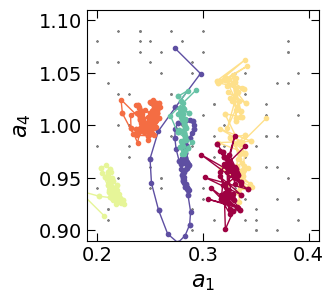

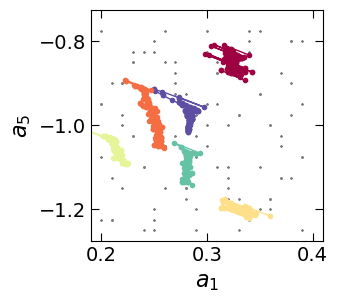

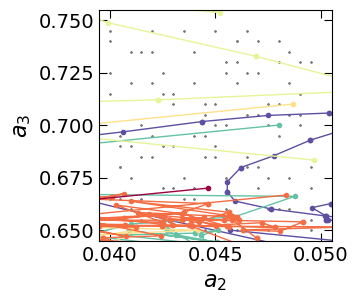

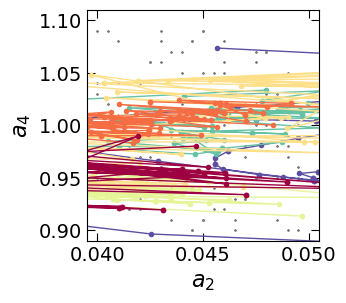

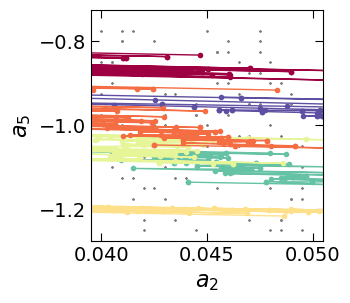

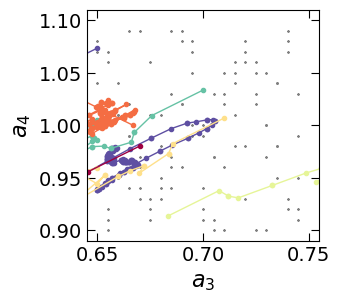

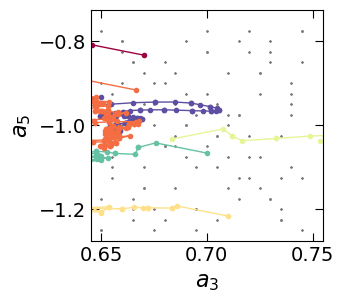

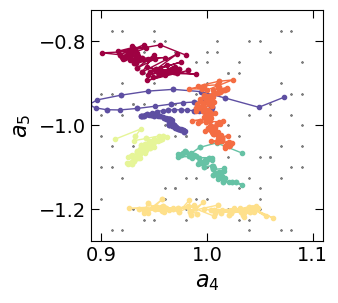

Reading from file: walks/desY1_lgNmax3.00_cosmo_all.txt


In [11]:
start_time = time()
walks = mnt.explore()
mnt.time_this(start_time)
mnt.visualize(walks)
data = mnt.load()

In [12]:
Nevals_mnt = mnt.N_evals_model + mnt.N_evals_deriv
ibest_mnt = np.argmin(data[0])
chi2_best_mnt = data[0,ibest_mnt]
pbest_mnt = data[1:,ibest_mnt].copy()  

model.params = mnt.cv(pbest_mnt)
model_best_mnt = model.forward(mnt.X)[0]

print('model:',mnt.N_evals_model,', derivs:',mnt.N_evals_deriv,', total:',Nevals_mnt)
print(chi2_best_mnt,dof)
print(pbest_mnt)
print(fid_params)

model: 775 , derivs: 546 , total: 1321
492.2578 494
[ 0.7584833   0.2803499   0.04957193  0.6265851   1.01454    -1.124389  ]
[ 0.801   0.2545  0.0485  0.682   0.971  -1.      0.012   0.012   0.012
  0.012   0.001  -0.019   0.009  -0.018   0.5     0.    ]


## Emulation

### GPR

In [13]:
GPR_Exists = Walks_Exist
CV_Thresh = 1e-3 
GPR_Dir = 'gpr/stats_'+id_str
gprt = GPRTrainer(data_file=mnt.walks_file,tmp_dir=GPR_Dir)

In [14]:
start_time = time()
Kernel = 'rbf' 
Max_Iter = 50 
if GPR_Exists:
    interpolator = gprt.train_gpr(verbose=True,vary_kernel=False,kernel=Kernel,skip_train=True)
else:
    interpolator = gprt.train_gpr(cv_thresh=CV_Thresh,verbose=True,vary_kernel=True,max_iter=Max_Iter,max_iter_vary=Max_Iter//5)
gprt.time_this(start_time)


Varying kernels to find best option
Maximum number of iterations reached. GPR may not be properly trained.
Maximum number of iterations reached. GPR may not be properly trained.
Maximum number of iterations reached. GPR may not be properly trained.

Kernel rbf is best choice: cv(1pc,99pc) after 10 iters = (-4.40e-03,4.99e-03)


... training with 100 of 775 samples
... ... current conv_stat = 1.00e+00; waiting for 1.00e-03
... setting up Gaussian Process Regression
... ... using anisotropic Gaussian (RBF) kernel
... ... starting with (norm,scale) = (1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00)
... ... fitting GP on training set (100 values; ~13% of input data)
0 min 2.91 seconds

... ... setting up Cholesky decomposition
... ... log-marg-like = 235.17
... ... best kernel params = (0.146,-2.898,-3.985,0.189,-0.354,-0.627,0.272)
1.08**2 * RBF(length_scale=[0.0551, 0.0186, 1.21, 0.702, 0.534, 1.31])
... ... writing best kernel params to file: gpr/stats_desY1_lgNm

### Neural network

In [ ]:
Xp = data[1:,:]
Yp = mnt.rv(data[0])
print(Xp.shape,Yp.shape,mnt.n_params)

# trim
print('Trimming training data...')
keep_these = np.ones(Yp.shape[1],dtype=bool)
for p in range(Xp.shape[0]):
    keep_these = keep_these & (Xp[p] >= mnt.param_mins[p]) & (Xp[p] <= mnt.param_maxs[p])
print('... keeping {0:d} of {1:d}'.format(np.where(keep_these)[0].size,keep_these.size))

Xp = Xp[:,keep_these]
Yp = Yp[:,keep_these]
print(Xp.shape,Yp.shape,mnt.n_params)

In [ ]:
# Build = not Walks_Exist

# Train_Frac = 0.8 
# Val_Frac = 0.2
# Test_Type = 'mse' # 'mse' or 'perc'
# Arch_Type = 'emulator:shallow'
# Min_Layer = 5
# Max_Layer = 5
# Max_Ex = [49*n_params]#[2*n_params,3*n_params]#,4*n_params] 
# LRates = [1.7e-4] # [3e-4] # None or list of floats
# Wt_Decays = [0.0] # non-empty list
# HTypes = ['tanh']
# N_Iter = 30 # ~3 for search, ~30 for final training
# TTL = 1e-3
# Loss_Type = 'square'
# Seed = None
# FileStem = 'net/NN_'+id_str

# start_time = time()
# bnn = BuildNN(Xp,Yp,train_frac=Train_Frac,arch_type=Arch_Type,max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,thresholds=None,
#               val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,test_type=Test_Type,htypes=HTypes,
#               target_test_stat=TTL,loss_type=Loss_Type,seed=Seed,file_stem=FileStem)
# if Build:
#     net,params_train,mtl = bnn.trainNN()
#     print('Best mean test loss = {0:.3e}'.format(mtl))
#     print('Setup params: ',net.params)
#     print('Training params: ',params_train)
# else:
#     net = bnn.load()
#     print('Loaded network with')
#     print('...    setup params: ',net.params)
#     params_train = bnn.load_train()
#     print('... training params: ',params_train)

# print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))
# bnn.time_this(start_time)

In [ ]:
Train = True
FileStem = 'net/NN_'+id_str
Seed = None #if Model_Type == 'ps' else 42

N_L = 5 # 5
Fac = 100 # 50
HLay = [Fac*n_params]*(N_L - 1)
HType = 'lrelu' 
LReLU_Slope = 1e-2
Wt_Decay = 0.3 # 0.3
LRate = 1e-6 # 3e-6
Max_Epoch = 100000#0
Check_After = 1000 
Reg_Fun = 'none' 

params_setup = {'data_dim':Xp.shape[0],'L':N_L,'n_layer':HLay+[1],'seed':Seed,'standardize':True,
                'reg_fun':Reg_Fun,'wt_decay':Wt_Decay,'lrelu_slope':LReLU_Slope,
                'atypes':[HType]*(N_L-1)+['lin'],'loss_type':'square','file_stem':FileStem}
params_train = {'lrate':LRate,'max_epoch':Max_Epoch,'mb_count':int(np.sqrt(0.8*Xp.shape[1])),'check_after':Check_After}
                #,'val_frac':Val_Frac}    
net = Sequential(params_setup)
if Train:
    start_time = time()
    net.train(Xp,Yp,params_train)
    net.save()
    print('... trained network with setup params: ',net.params)
    net.time_this(start_time)
else:
    net.load()
    net.load_history()
    print('Loaded network with setup params: ',net.params)
print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))
print ('... done')

In [ ]:
#if Build:
plt.figure(figsize=(4,4))
plt.xlim(0.5,2*params_train['max_epoch'])
# plt.ylim(1e-4,1e7)
plt.yscale('log')
plt.xscale('log')
nn_label = '{0:1d}-layer NN'.format(net.L)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label=nn_label+': train')
plt.plot(net.epochs,net.val_loss,'r-',lw=0.5,label=nn_label+': val')
plt.legend()
plt.show()
min_val_loss = net.val_loss[net.val_loss > 0.0].min()
print('min val loss = {0:.3e}'.format(min_val_loss))

### Testing emulators

In [15]:
print('True loss calculation')
start_time = time()
###############
Nsamp_ev = 1000
Xp_ev = mnt.gen_latin_hypercube(Nsamp=Nsamp_ev,dim=mnt.n_params,param_mins=mnt.param_mins,param_maxs=mnt.param_maxs)
Yp_ev = np.zeros((1,Nsamp_ev))
loss_params_ev = copy.deepcopy(loss_params)
loss_params_ev['Y_full'] = mnt.Y
for n in range(Nsamp_ev):
    model.params[:,0] = Xp_ev[n]
    Loss_ev = mnt.loss_module(loss_params_ev)
    Yp_ev[0,n] = Loss_ev.forward(model.calc_model(mnt.X))
    mnt.status_bar(n,Nsamp_ev)
Xp_ev = Xp_ev.T
###############
mnt.time_this(start_time)

# print('NN prediction for loss')
# start_time = time()
# Yp_ev_pred_nn = net.predict(Xp_ev)
# mnt.time_this(start_time)

# resid_nn = Yp_ev_pred_nn[0]/Yp_ev[0] - 1

print('GPR prediction for loss')
start_time = time()
Yp_ev_pred_gpr = gprt.predict(Xp_ev.T,interpolator)
mnt.time_this(start_time)

resid_gpr = Yp_ev_pred_gpr/Yp_ev[0] - 1

True loss calculation
[....................] 100% done
6 min 26.36 seconds

GPR prediction for loss
0 min 0.01 seconds



In [16]:
# SS_Res_nn = np.sum((Yp_ev_pred_nn[0] - Yp_ev[0])**2) 
# SS_Tot_nn = np.sum((Yp_ev_pred_nn[0] - Yp_ev_pred_nn[0].mean())**2) 
# R2_nn = 1 - SS_Res_nn/(SS_Tot_nn + 1e-15)

SS_Res_gpr = np.sum((Yp_ev_pred_gpr - Yp_ev[0])**2) 
SS_Tot_gpr = np.sum((Yp_ev_pred_gpr - Yp_ev_pred_gpr.mean())**2) 
R2_gpr = 1 - SS_Res_gpr/(SS_Tot_gpr + 1e-15)

print('R2 scores:')
# print('...  NN: {0:.4f}'.format(R2_nn))
print('... GPR: {0:.4f}'.format(R2_gpr))

R2 scores:
... GPR: 1.0000


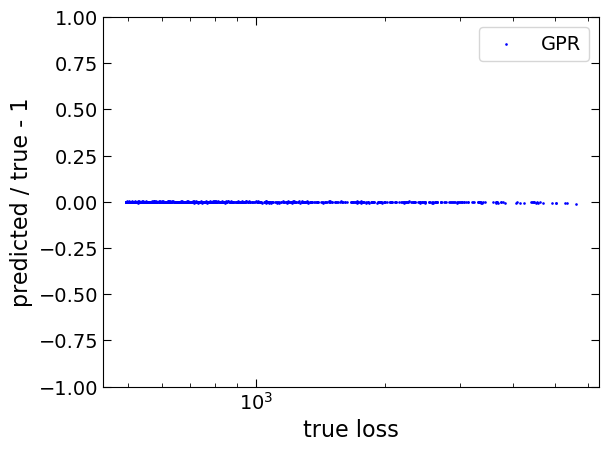

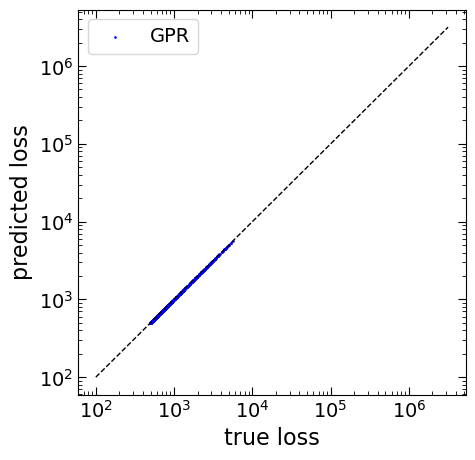

In [17]:
plt.xscale('log')
plt.xlabel('true loss')
plt.ylabel('predicted / true - 1')
plt.ylim(-1,1)
# plt.scatter(Yp_ev[0],resid_nn,s=0.8,color='r',label='NN')
plt.scatter(Yp_ev[0],resid_gpr,s=0.8,color='b',label='GPR')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('true loss')
plt.ylabel('predicted loss')
plt.plot(np.logspace(2.0,6.5,10),np.logspace(2.0,6.5,10),'k--',lw=1)
# plt.scatter(Yp_ev[0],Yp_ev_pred_nn[0],s=0.8,color='r',label='NN')
plt.scatter(Yp_ev[0],Yp_ev_pred_gpr,s=0.8,color='b',label='GPR')
plt.legend()
plt.show()

## MCMC

In [18]:
Like_Dir = '../../code/likes/'
Plots_Dir = 'plots/'

Run_Cobaya = False
Run_NN = False
Run_GPR = True

Max_Samples = 1000000
Rminus1_Stop = 0.01
Rminus1_CL_Stop = 0.05 # 0.05
Rminus1_CL_Level = 0.95 # 95

Burn_In = 0

Params_List = mnt.model_inst.varied_params
Latex_List = mnt.model_inst.varied_params # change this

info = {}
info['params'] = {}
for p in range(len(Params_List)):
    ref = pbest_mnt[p] 
    info['params'][Params_List[p]] = {'ref':{'min':ref-0.01,'max':ref+0.01},
                                      'prior':{'min':mnt.param_mins[p],'max':mnt.param_maxs[p]},
                                      'proposal':0.005,'latex':Latex_List[p]}

info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 10000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}
info_output = 'stats/chains/'+id_str
info['output'] = info_output
info["force"] = True    

if Run_NN:
    info_nn = copy.deepcopy(info)
    info_nn['likelihood'] = {'likelihoods.EmulLike':
                             {'python_path':Like_Dir}}
    info_nn['theory'] = {'likelihoods.NNTheory':
                             {'python_path':Like_Dir,
                              'net':net,'keys':Params_List}}
    info_nn['output'] = info_output+'_nn'

if Run_GPR:
    info_gpr = copy.deepcopy(info)
    info_gpr['likelihood'] = {'likelihoods.EmulLike':
                                 {'python_path':Like_Dir}}
    info_gpr['theory'] = {'likelihoods.GPRTheory':
                             {'python_path':Like_Dir,
                              'gprt':gprt,'interpolator':interpolator,'keys':Params_List}}
    info_gpr['output'] = info_output+'_gpr'


In [19]:
if Run_Cobaya:
    start_time = time()
    updated_info, sampler = run(info)
    Neval_cobaya = pic.calc_Neval(sampler)
    print('Neval_cobaya = {0:d}'.format(Neval_cobaya))
    mnt.time_this(start_time)
else:
    Neval_cobaya = 558703 if mnt.n_params == 9 else (13494 if mnt.n_params == 4 else 13494)
    print('Chains (hopefully) exist!')

Chains (hopefully) exist!


In [20]:
if Run_NN:
    start_time = time()
    updated_info_nn, sampler_nn = run(info_nn)
    Neval_nn = pic.calc_Neval(sampler_nn)
    print('Neval_nn = {0:d}'.format(Neval_nn))
    mnt.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

Chains (hopefully) exist!


In [21]:
if Run_GPR:
    start_time = time()
    updated_info_gpr, sampler_gpr = run(info_gpr)
    Neval_gpr = pic.calc_Neval(sampler_gpr)
    print('Neval_gpr = {0:d}'.format(Neval_gpr))
    mnt.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

[output] Output to be read-from/written-into folder 'stats/chains', with prefix 'desY1_lgNmax3.00_cosmo_gpr'
[output] Found existing info files with the requested output prefix: 'stats/chains/desY1_lgNmax3.00_cosmo_gpr'
[output] Will delete previous products ('force' was requested).


[vivaldi-piccolo:82357] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


[mcmc] Getting initial point... (this may take a few seconds)
[prior] *WARNING* If stuck here, maybe it is not possible to sample from the reference pdf a point with non-null prior. Check that the reference pdf and the prior are consistent.
[prior] *ERROR* Could not sample from the reference pdf a point with non-null prior density after 10000 tries. Maybe your prior is improper of your reference pdf is null-defined in the domain of the prior.


LoggedError: Could not sample from the reference pdf a point with non-null prior density after 10000 tries. Maybe your prior is improper of your reference pdf is null-defined in the domain of the prior.

In [ ]:
Save_Fig = False

Show_MCMC = False
Show_NN = False
Show_GPR = True

In [ ]:
Burn_Frac = 0.3
rng = np.random.RandomState(42)
dim = n_params

start_time = time()

if Show_MCMC:
    gd_sample = loadMCSamples(os.path.abspath('cobaya_chains/chains/reion_uvlf_9p'),settings={'ignore_rows':Burn_Frac})
    gd_sample.label = 'MCMC: {0:d} evals'.format(Neval_cobaya) 
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    sample = gd_sample.samples
    sample = sample.T
    ibest = sample[-2].argmin()
    mcmc_best = sample[:dim,ibest]
    mcmc_chi2 = sample[-2,ibest]
    pval = sysp.gammainc(mcmc_chi2/2,dof/2)
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    print('MCMC...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2,dof,mcmc_chi2/dof,pval))

if Show_NN:
    gd_sample_nn = loadMCSamples(os.path.abspath(info_nn["output"]),settings={'ignore_rows':Burn_Frac})
    gd_sample_nn.label = '     NN: {0:d} of {1:d} evals'.format(Xp.shape[1],Nevals_mnt)
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_nn = gd_sample_nn.getCovMat().matrix[:dim, :dim]
    sample_nn = gd_sample_nn.samples
    sample_nn = sample_nn.T
    ibest_nn = sample_nn[-2].argmin()
    mcmc_best_nn = sample_nn[:dim,ibest_nn]
    mcmc_chi2_nn = sample_nn[-2,ibest_nn]
    pval_nn = sysp.gammainc(mcmc_chi2_nn/2,dof/2)
    mcmc_sig_nn = np.sqrt(np.diag(mcmc_covmat_nn))
    print('NN...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best_nn])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_nn])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_nn,dof,mcmc_chi2_nn/dof,pval_nn))

if Show_GPR:
    gd_sample_gpr = loadMCSamples(os.path.abspath(info_gpr["output"]),settings={'ignore_rows':Burn_Frac})
    gd_sample_gpr.label = '   GPR: {0:d} of {1:d} evals'.format(gprt.pred_var.size,Nevals_mnt)
    print(gd_sample_gpr.label)
    # gd_sample_gpr.label = '   GPR: {0:d} evals'.format(Nevals_mnt)
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_gpr = gd_sample_gpr.getCovMat().matrix[:dim, :dim]
    sample_gpr = gd_sample_gpr.samples
    sample_gpr = sample_gpr.T
    ibest_gpr = sample_gpr[-2].argmin()
    mcmc_best_gpr = sample_gpr[:dim,ibest_gpr]
    mcmc_chi2_gpr = sample_gpr[-2,ibest_gpr]
    pval_gpr = sysp.gammainc(mcmc_chi2_gpr/2,dof/2)
    mcmc_sig_gpr = np.sqrt(np.diag(mcmc_covmat_gpr))
    print('GPR...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_best_gpr])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params-1)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_gpr])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_gpr,dof,mcmc_chi2_gpr/dof,pval_gpr))

plot_param_list = Params_List
Subplot_Size = 1.6 

gdplot = gdplt.get_subplot_plotter(subplot_size=Subplot_Size)
gdplot.settings.num_plot_contours = 3
gdplot.settings.axes_fontsize = FS3
gdplot.settings.axes_labelsize = FS2
gdplot.settings.title_limit_fontsize = FS3

show_list = []
fill_list = []
col_list = []
if Show_MCMC:
    show_list.append(gd_sample)
    fill_list.append(True)
    col_list.append('indigo')
if Show_NN:
    show_list.append(gd_sample_nn)
    fill_list.append(True)
    col_list.append('crimson')
if Show_GPR:
    show_list.append(gd_sample_gpr)
    fill_list.append(True)
    col_list.append('darkgreen')
gdplot.triangle_plot(show_list, plot_param_list,filled=fill_list,
                     contour_colors=col_list,legend_loc='upper right',
                     title_limit=0)
for par_y in range(dim):
    str_y = plot_param_list[par_y]
    ax = gdplot.subplots[par_y,par_y]
    if Show_MCMC:
        ax.axvline(mcmc_best[par_y],c='indigo',ls='--',lw=1,alpha=0.6)
    if Show_NN:
        ax.axvline(mcmc_best_nn[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
    if Show_GPR:
        ax.axvline(mcmc_best_gpr[par_y],c='darkgreen',ls='--',lw=1,alpha=0.6)
    for par_x in range(par_y):
        str_x = plot_param_list[par_x]
        #print(par_x,par_y,':',str_x,str_y)
        ax = gdplot.subplots[par_y,par_x]
        if Show_MCMC:
            ax.scatter([mcmc_best[par_x]],[mcmc_best[par_y]],marker='*',s=50,c='aliceblue')
            ax.axvline(mcmc_best[par_x],c='indigo',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best[par_y],c='indigo',ls='--',lw=1.5,alpha=0.6)
        if Show_NN:
            ax.scatter([mcmc_best_nn[par_x]],[mcmc_best_nn[par_y]],marker='*',s=50,c='peachpuff')
            ax.axvline(mcmc_best_nn[par_x],c='crimson',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best_nn[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
        if Show_GPR:
            ax.scatter([mcmc_best_gpr[par_x]],[mcmc_best_gpr[par_y]],marker='*',s=50,c='lightcyan')
            ax.axvline(mcmc_best_gpr[par_x],c='darkgreen',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best_gpr[par_y],c='darkgreen',ls='--',lw=1,alpha=0.6)

if Save_Fig:
    filename = 'contours_'+id_str+'.png'
    print('Writing to file: '+Plots_Dir+filename)
    gdplot.export(fname=filename,adir=Plots_Dir)

mnt.time_this(start_time)